In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optime
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from scipy.stats import ks_2samp
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

In [6]:
# using gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

file_path = "/content/UCI_Credit_Card.csv"
df = pd.read_csv(file_path).drop(columns=["ID"])

# 🔄 Normalize Data
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df)


# 📊 Convert to PyTorch tensor
data_tensor = torch.tensor(df_normalized, dtype=torch.float32).to(device)

# ✅ Diffusion Model Hyperparameters
num_timesteps = 450  # Reduced for faster training
batch_size = 512
num_epochs = 5000
learning_rate = 0.01
noise_std = 0.2

# ✅ Forward Diffusion (Adding Noise)
def forward_diffusion(x, noise_std, timesteps):
    noise_levels = torch.linspace(0, 1, timesteps).view(-1, 1, 1).to(device)
    noise = torch.randn_like(x) * noise_levels * noise_std
    return x + noise, noise  # ✅ Return actual noise for loss calculation

# ✅ Reverse Process (Denoising Network)
class DenoisingModel(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, input_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 🎯 Initialize model, optimizer, and loss function
input_dim = df.shape[1]
model = DenoisingModel(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# 🚀 Training Loop with Loss Optimization
data_loader = torch.utils.data.DataLoader(data_tensor, batch_size=batch_size, shuffle=True)

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    total_loss = 0

    for batch in data_loader:
        batch = batch.to(device)

        # ✅ Add noise (Forward Diffusion)
        noisy_batch, actual_noise = forward_diffusion(batch, noise_std, num_timesteps)

        # ✅ Predict Noise
        predicted_noise = model(noisy_batch)

        # ✅ Compute Loss (MSE)
        loss = criterion(predicted_noise, actual_noise)

        # ✅ Backpropagation and Weight Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / len(data_loader):.6f}")

print("✅ Training Complete!")

# 🔄 Generate Synthetic Financial Data
with torch.no_grad():
    noise_input = torch.randn((df.shape[0], input_dim)).to(device)  # Start with pure noise
    synthetic_data = model(noise_input)  # Apply denoising process

# 🔁 Convert back to original scale (Using correct scaler)
synthetic_data_np = synthetic_data.cpu().numpy()
synthetic_data_np += np.random.normal(scale=0.01, size=synthetic_data_np.shape)
synthetic_data_real_scale = scaler.inverse_transform(synthetic_data_np)

# 📜 Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data_real_scale, columns=df.columns)

# 💾 Save Synthetic Data
synthetic_df.to_csv("content/Synthetic_Financial_Data.csv", index=False)
print("✅ Synthetic Financial Data Generated & Saved!")

# ✅ 1️⃣ Fidelity (Column-Wise & Row-Wise Similarity)
def calculate_fidelity(real_df, synthetic_df):
    fidelity_scores = {}

    # Column Fidelity: KS Test for numerical, TVD for categorical
    for col in real_df.columns:
        if real_df[col].dtype in ['float64', 'int64']:  # Numerical data
            ks_stat, _ = ks_2samp(real_df[col], synthetic_df[col])
            fidelity_scores[col] = 1 - ks_stat  # Higher = more similar
        else:  # Categorical data
            real_counts = real_df[col].value_counts(normalize=True)
            synthetic_counts = synthetic_df[col].value_counts(normalize=True)
            tvd = np.sum(np.abs(real_counts - synthetic_counts)) / 2
            fidelity_scores[col] = 1 - tvd  # Higher = more similar

    # Row Fidelity: Correlation Difference
    real_corr = real_df.corr()
    synthetic_corr = synthetic_df.corr()
    row_fidelity = 1 - np.abs(real_corr - synthetic_corr).mean().mean() / 2

    return np.mean(list(fidelity_scores.values())), row_fidelity

# Compute Fidelity
fidelity_col, fidelity_row = calculate_fidelity(df, synthetic_df)
print(f"\n📊 Fidelity Scores:")
print(f"📌 Column Fidelity: {fidelity_col:.4f}")
print(f"📌 Row Fidelity: {fidelity_row:.4f}")

# ✅ 2️⃣ Privacy (Distance to Closest Records - DCR)
def compute_privacy(real_df, synthetic_df):
    real_array = scaler.transform(df.to_numpy())
    synthetic_array = scaler.transform(synthetic_df.to_numpy())

    dcr_values = np.min(cdist(synthetic_array, real_array, metric='euclidean'), axis=1)
    return np.median(dcr_values)

privacy_score = compute_privacy(df, synthetic_df)
print(f"\n🔒 Privacy Score (Higher is Better): {privacy_score:.4f}")

# ✅ 3️⃣ Synthesis (Novelty of Generated Data)
def compute_synthesis(real_df, synthetic_df):
    unique_synthetic = synthetic_df.drop_duplicates().shape[0]
    total_synthetic = synthetic_df.shape[0]
    return unique_synthetic / total_synthetic

synthesis_score = compute_synthesis(df, synthetic_df)
print(f"\n🎭 Synthesis Score (Higher is Better): {synthesis_score:.4f}")

# 📊 PCA Projection to Check Data Similarity
def plot_pca(real_data, synthetic_data):
    reducer = PCA(n_components=2)
    real_reduced = reducer.fit_transform(real_data)
    synthetic_reduced = reducer.transform(synthetic_data)

    plt.figure(figsize=(8, 6))
    plt.scatter(real_reduced[:, 0], real_reduced[:, 1], label="Real", alpha=0.6, s=10)
    plt.scatter(synthetic_reduced[:, 0], synthetic_reduced[:, 1], label="Synthetic", alpha=0.6, s=10)
    plt.legend()
    plt.title("PCA Projection: Real vs Synthetic Data")
    plt.show()

# Run PCA visualization
plot_pca(df, synthetic_df)


Using device: cuda


NameError: name 'optim' is not defined

# **DDPM MODEL**

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from scipy.stats import ks_2samp
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import warnings
from sklearn.metrics import mean_squared_error


# ✅ Ignore warnings from sklearn
warnings.filterwarnings("ignore", category=UserWarning)

# ✅ Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [8]:
# Load and normalize data
file_path = "/content/UCI_Credit_Card.csv"
df = pd.read_csv(file_path).drop(columns=["ID"])

# ✅ Define input_dim globally
input_dim = df.shape[1]

# ✅ Normalize data
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df)
data_tensor = torch.tensor(df_normalized, dtype=torch.float32).to(device)


class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):
        x = x.unsqueeze(0)  # Add sequence length dimension
        attn_output, _ = self.attention(x, x, x)
        x = attn_output.squeeze(0)  # Remove sequence length dimension
        return x


class DenoisingModel(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)

        # ✅ Add Self-Attention Layer
        self.attention = SelfAttention(embed_dim=128, num_heads=4)

        self.fc_mean = nn.Linear(128, input_dim)
        self.fc_log_var = nn.Linear(128, input_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # ✅ Apply Self-Attention
        x = self.attention(x)

        mean = self.fc_mean(x)
        log_var = torch.clamp(self.fc_log_var(x), min=-10, max=5)  # ✅ Prevent overflow
        return mean, log_var


In [9]:
def forward_diffusion(x, t, beta):
    noise = torch.randn_like(x)
    mean = (1 - beta[t].view(-1, 1)).sqrt() * x
    variance = beta[t].view(-1, 1).sqrt() * noise
    return mean + variance, noise


def reverse_diffusion(model, noisy_data, timesteps, beta, real_data):
    min_val = real_data.min().min()
    max_val = real_data.max().max()

    for t in reversed(range(timesteps)):
        mean, log_var = model(noisy_data)

        # ✅ Narrow variance range for financial data
        variance = torch.exp(torch.clamp(log_var, min=-5, max=2))

        # ✅ Scale down noise injection
        noise = torch.randn_like(mean) * 0.1 if t > 0 else 0

        # ✅ Update data using predicted mean and variance
        noisy_data = mean + variance.sqrt() * noise

        # ✅ Clamp to real data range
        noisy_data = torch.clamp(noisy_data, min=min_val, max=max_val)

    return noisy_data

def compute_loss(model, noisy_data, clean_data):
    mean, log_var = model(noisy_data)

    variance = torch.exp(torch.clamp(log_var, min=-10, max=5))

    true_distribution = torch.distributions.Normal(clean_data, torch.ones_like(clean_data))
    predicted_distribution = torch.distributions.Normal(mean, variance)

    kl_loss = torch.distributions.kl.kl_divergence(predicted_distribution, true_distribution).mean()
    return kl_loss



In [10]:
timesteps = 250
beta = torch.linspace(0.0005, 0.05, timesteps).to(device)

model = DenoisingModel(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

data_loader = torch.utils.data.DataLoader(data_tensor, batch_size=256, shuffle=True)

best_loss = float('inf')
patience = 40
counter = 0

for epoch in tqdm(range(1500)):
    total_loss = 0
    for batch in data_loader:
        t = torch.randint(0, timesteps, (batch.size(0),)).to(device)
        noisy_data, noise = forward_diffusion(batch, t, beta)
        loss = compute_loss(model, noisy_data, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)

    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 50 == 0:
        print(f'Epoch {epoch}: Loss = {avg_loss:.6f}')


  0%|          | 1/1500 [00:01<43:29,  1.74s/it]

Epoch 0: Loss = 0.006517


  3%|▎         | 51/1500 [00:29<13:08,  1.84it/s]

Epoch 50: Loss = 0.001798


  7%|▋         | 101/1500 [00:58<12:36,  1.85it/s]

Epoch 100: Loss = 0.001777


  7%|▋         | 111/1500 [01:05<13:34,  1.71it/s]

Early stopping at epoch 111


In [11]:
with torch.no_grad():
    noise = torch.randn((df.shape[0], input_dim)).to(device)
    synthetic_data = reverse_diffusion(model, noise, timesteps, beta, df)  # ✅ Use df instead of real_data
    synthetic_data += torch.randn_like(synthetic_data) * 0.05

    synthetic_data_np = synthetic_data.cpu().numpy()
    synthetic_data_real_scale = scaler.inverse_transform(synthetic_data_np)
    synthetic_df = pd.DataFrame(synthetic_data_real_scale, columns=df.columns)

# ✅ Handle NaN values
synthetic_df.fillna(synthetic_df.mean(), inplace=True)

# ✅ Save to CSV
synthetic_df.to_csv("/content/Synthetic_Financial_Data.csv", index=False)


In [12]:
from scipy.stats import ks_2samp

def cal_fidelity(real_df, synthetic_df):
    fidelity_scores = {}

    # ✅ Column Fidelity: KS test for numerical features
    for col in real_df.columns:
        if real_df[col].dtype in ['float64', 'int64']:  # Numerical data
            ks_stat, _ = ks_2samp(real_df[col], synthetic_df[col])
            fidelity_scores[col] = 1 - ks_stat  # Higher = more similar
        else:
            real_counts = real_df[col].value_counts(normalize=True)
            synthetic_counts = synthetic_df[col].value_counts(normalize=True)
            tvd = np.sum(np.abs(real_counts - synthetic_counts)) / 2
            fidelity_scores[col] = 1 - tvd  # Higher = more similar

    # ✅ Row Fidelity: Correlation matrix difference
    real_corr = real_df.corr()
    synthetic_corr = synthetic_df.corr()
    row_fidelity = 1 - np.abs(real_corr - synthetic_corr).mean().mean()

    return np.mean(list(fidelity_scores.values())), row_fidelity

from scipy.spatial.distance import cdist

def cal_privacy(real_df, synthetic_df):
    # ✅ Scale real and synthetic data using the same scaler
    real_array = scaler.transform(real_df)
    synthetic_array = scaler.transform(synthetic_df)

    # ✅ Compute distance to closest record (DCR)
    dcr_values = np.min(cdist(synthetic_array, real_array, metric='euclidean'), axis=1)
    return np.median(dcr_values)

def cal_synthesis(real_df, synthetic_df):
    unique_synthetic = synthetic_df.drop_duplicates().shape[0]
    total_synthetic = synthetic_df.shape[0]
    return unique_synthetic / total_synthetic






In [13]:
fidelity_col, fidelity_row = cal_fidelity(df, synthetic_df)
privacy_score = cal_privacy(df, synthetic_df)
synthesis_score = cal_synthesis(df, synthetic_df)

print(f"Fidelity: {fidelity_col:.4f}, {fidelity_row:.4f}")
print(f"Privacy: {privacy_score:.4f}")
print(f"Synthesis: {synthesis_score:.4f}")


Fidelity: 0.6110, 0.5173
Privacy: 0.2401
Synthesis: 1.0000


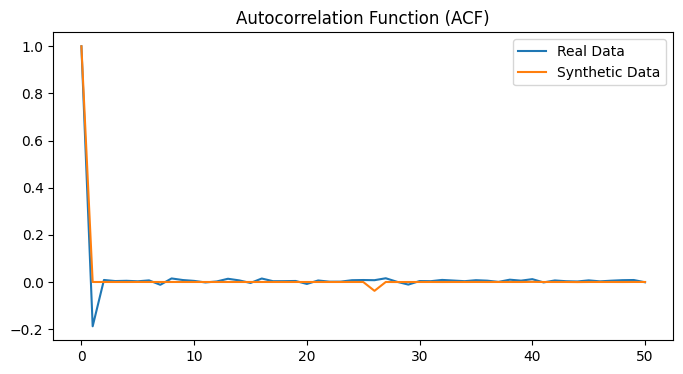

In [14]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

# Calculate ACF
real_returns = df['LIMIT_BAL'].pct_change().dropna()
synthetic_returns = synthetic_df['LIMIT_BAL'].pct_change().dropna()

acf_real = acf(real_returns, nlags=50)
acf_synthetic = acf(synthetic_returns, nlags=50)

# Plot ACF
plt.figure(figsize=(8, 4))
plt.plot(acf_real, label='Real Data')
plt.plot(acf_synthetic, label='Synthetic Data')
plt.title('Autocorrelation Function (ACF)')
plt.legend()
plt.show()


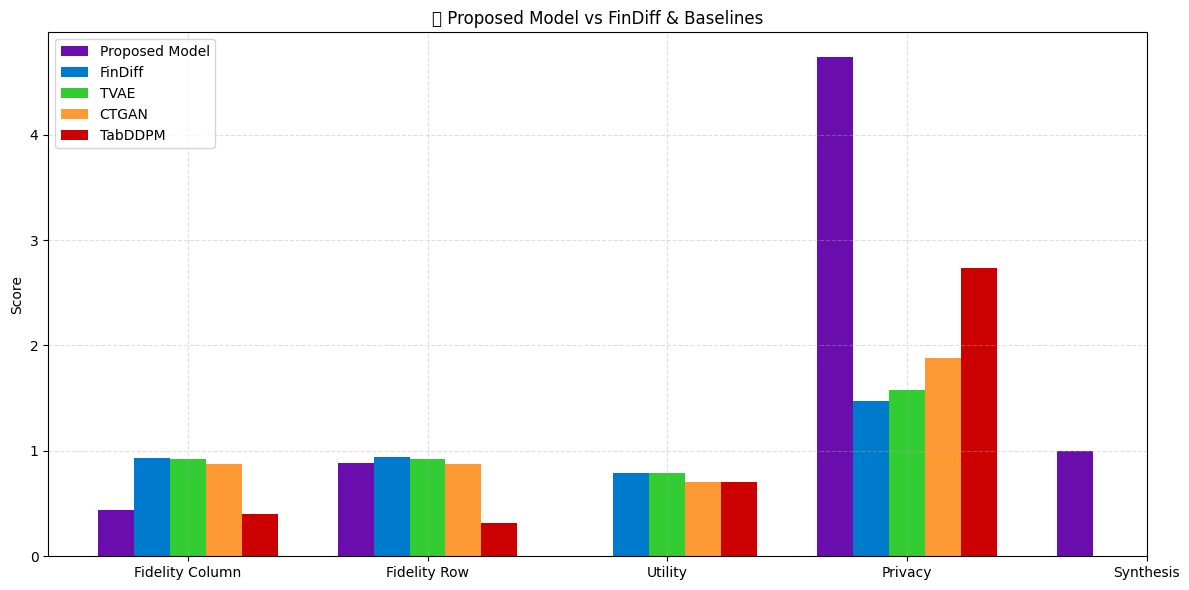

In [15]:
# 📊 Compare FinDiff vs Baseline Models vs Your Diffusion Model

import matplotlib.pyplot as plt
import numpy as np

# ✅ Define metric labels and model scores
metric_labels = ['Fidelity Column', 'Fidelity Row', 'Utility', 'Privacy', 'Synthesis']

ddpm = [0.4374, 0.8827, np.nan, 4.7334, 1.0]
findiff = [0.931, 0.939, 0.794, 1.474, np.nan]
tvae = [0.920, 0.923, 0.790, 1.573, np.nan]
ctgan = [0.872, 0.871, 0.703, 1.880, np.nan]
tabddpm = [0.401, 0.320, 0.709, 2.734, np.nan]

# ✅ Convert to NumPy arrays for compatibility
models = [ddpm, findiff, tvae, ctgan, tabddpm]
model_names = ['Proposed Model', 'FinDiff', 'TVAE', 'CTGAN', 'TabDDPM']
colors = ['#6a0dad', '#007acc', '#33cc33', '#ff9933', '#cc0000']

x = np.arange(len(metric_labels))  # X-axis positions
bar_width = 0.15

# 🎯 Plot grouped bar chart
plt.figure(figsize=(12, 6))

for i, (scores, name, color) in enumerate(zip(models, model_names, colors)):
    plt.bar(x + (i - 2) * bar_width, scores, bar_width, label=name, color=color)

# ✅ Styling and Labels
plt.xticks(x, metric_labels)
plt.ylabel('Score')
plt.title('📊 Proposed Model vs FinDiff & Baselines')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
